In [1]:
from linopy import *
import pandas as pd
import xarray as xr
from linopy import Model
from matplotlib import cm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Data
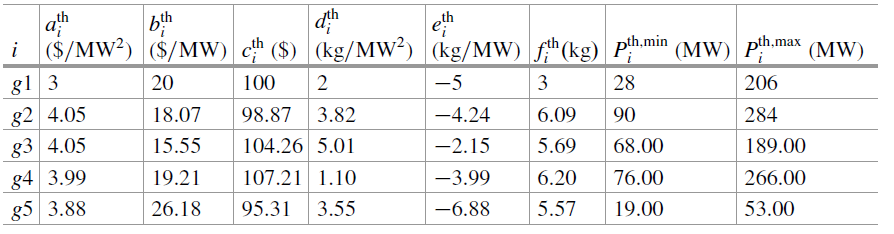

In [2]:
data = pd.read_csv('data.csv', delimiter = ' ', index_col= 'units')
data

,a,b,c,d,e,f,Pmin,Pmax
units,,,,,,,,
g1,3.00,20.00,100.00,2.00,-5.00,3.00,28,206
g2,4.05,18.07,98.87,3.82,-4.24,6.09,90,284
g3,4.05,15.55,104.26,5.01,-2.15,5.69,68,189
g4,3.99,19.21,107.21,1.10,-3.99,6.20,76,266
g5,3.88,26.18,95.31,3.55,-6.88,5.57,19,53


In [3]:
data = xr.Dataset(data)
data_array = data.to_array()

In [21]:
data

<xarray.Dataset>
Dimensions:  (units: 5)
Coordinates:
  * units    (units) object 'g1' 'g2' 'g3' 'g4' 'g5'
Data variables:
    a        (units) float64 3.0 4.05 4.05 3.99 3.88
    b        (units) float64 20.0 18.07 15.55 19.21 26.18
    c        (units) float64 100.0 98.87 104.3 107.2 95.31
    d        (units) float64 2.0 3.82 5.01 1.1 3.55
    e        (units) float64 -5.0 -4.24 -2.15 -3.99 -6.88
    f        (units) float64 3.0 6.09 5.69 6.2 5.57
    Pmin     (units) int64 28 90 68 76 19
    Pmax     (units) int64 206 284 189 266 53

### Algebraic problem description
Thermal Unit Economic Dispatch

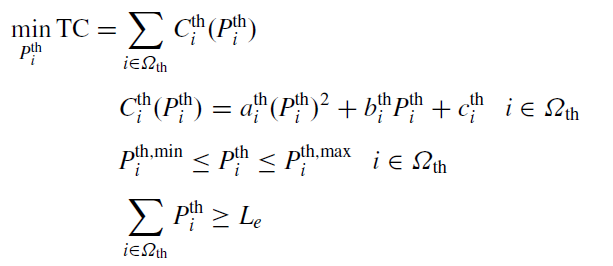

In [4]:
m = Model()

### Variable Definition

In [5]:
Pgen = m.add_variables(lower= data['Pmin'], upper= data['Pmax'] , coords= [data_array.units], name = 'Pgen')

### Pgen bounds

In [6]:
Pgen

Variable (units: 5)
-------------------
[g1]: Pgen[g1] ∈ [28, 206]
[g2]: Pgen[g2] ∈ [90, 284]
[g3]: Pgen[g3] ∈ [68, 189]
[g4]: Pgen[g4] ∈ [76, 266]
[g5]: Pgen[g5] ∈ [19, 53]

### In Linopy, constant values cannot be added as in GAMS in OF.

In [7]:
# obj = m.add_objective((Pgen*Pgen*data_array[0]+ Pgen*data['b'] + data['c']).sum())

In [8]:
obj = m.add_objective(Pgen*Pgen*data_array[0]+ Pgen*data['b'] )

### Load constraint

In [9]:
m.add_constraints(Pgen.sum()>=400)

Constraint `con0`
-----------------
+1 Pgen[g1] + 1 Pgen[g2] + 1 Pgen[g3] + 1 Pgen[g4] + 1 Pgen[g5] ≥ 400.0

In [10]:
m.solve()
m.dual

<xarray.Dataset>
Dimensions:  ()
Data variables:
    con0     float64 637.1

In [11]:
color = cm.inferno_r(np.linspace(0.4, .8, 5))
color

array([[0.865006, 0.316822, 0.226055, 1.      ],
       [0.729909, 0.212759, 0.333861, 1.      ],
       [0.578304, 0.148039, 0.404411, 1.      ],
       [0.416331, 0.090203, 0.432943, 1.      ],
       [0.258234, 0.038571, 0.406485, 1.      ]])

Text(0, 0.5, 'Power(MW)')

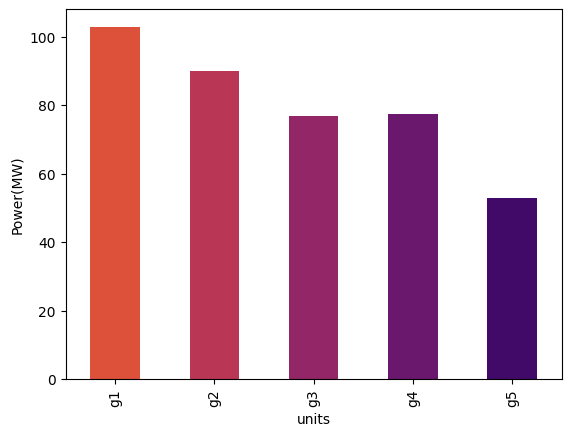

In [12]:
sol = m.solution.to_dataframe()
sol['Pgen'].plot.bar(color= color).set_ylabel('Power(MW)')

### Sensitivity Analysis
- The problem is feasible for any load value in the interval [281 : 998]
- Obtain the values of the objective function and the power produced by each unit for every load value.
- Plot all the results obtained. It should look similar to the one below
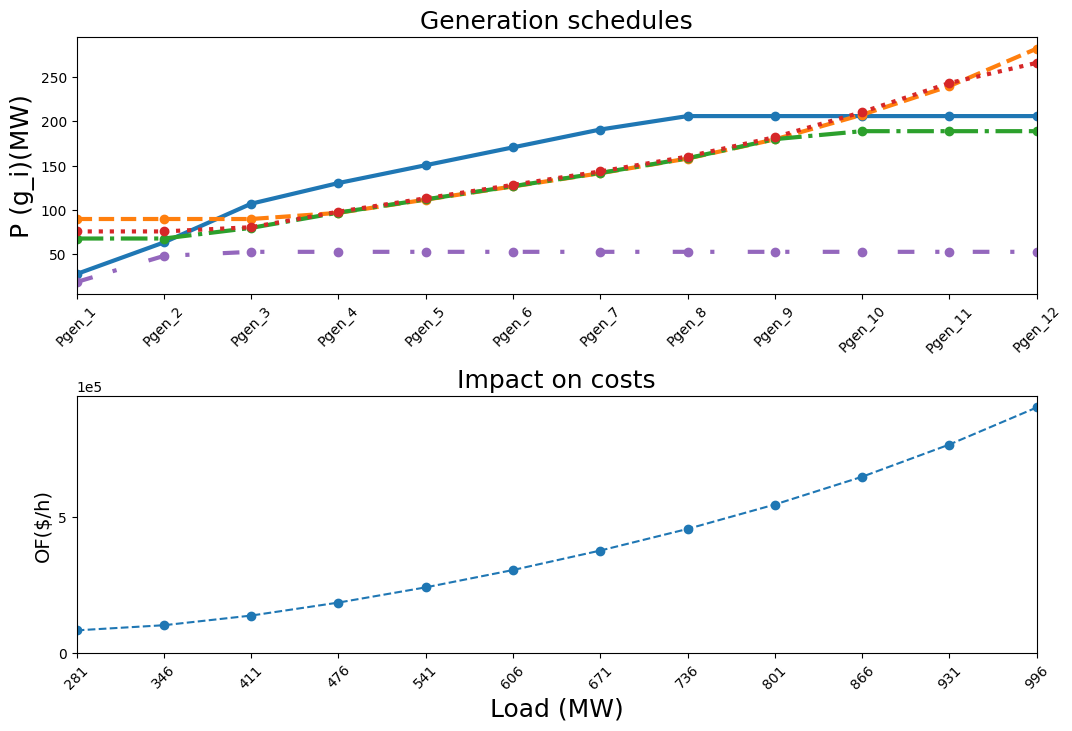


In [13]:
load = list(range(281,998, int((998-281)/11)))
load


[281, 346, 411, 476, 541, 606, 671, 736, 801, 866, 931, 996]

In [14]:
def load_input(load , data, data_array):
    m = Model()
    Pgen = m.add_variables(lower= data['Pmin'], upper= data['Pmax'] , coords= [data_array.units], name = 'Pgen')
    m.add_objective(Pgen*Pgen*data_array[0]+ Pgen*data['b'] )
    m.add_constraints(Pgen.sum()>=load)
    m.solve()
    return m.solution.to_dataframe(), m.objective.value

In [20]:
[data_array.units]

[<xarray.DataArray 'units' (units: 5)>
 array(['g1', 'g2', 'g3', 'g4', 'g5'], dtype=object)
 Coordinates:
   * units    (units) object 'g1' 'g2' 'g3' 'g4' 'g5']

In [15]:
sol, obj = load_input(400, data, data_array)


### Store all solutions in a list

In [16]:
sol = []
obj = []
for i in load:
    sol1=((load_input(i, data, data_array)))[0]
    sol.append(sol1)
    obj1=((load_input(i, data, data_array)))[1]
    obj.append(obj1)
    # obj.append((load_input(i, data, data_array)))[1]

In [17]:
sol = pd.concat(sol).reset_index()
new_df = sol.pivot_table(index='units', columns=sol.groupby('units').cumcount()+1, values='Pgen')
column_names = [f'Pgen_{i}' for i in range(1, 13)]
new_df.columns = column_names
new_df = new_df.transpose()

### Plotting results

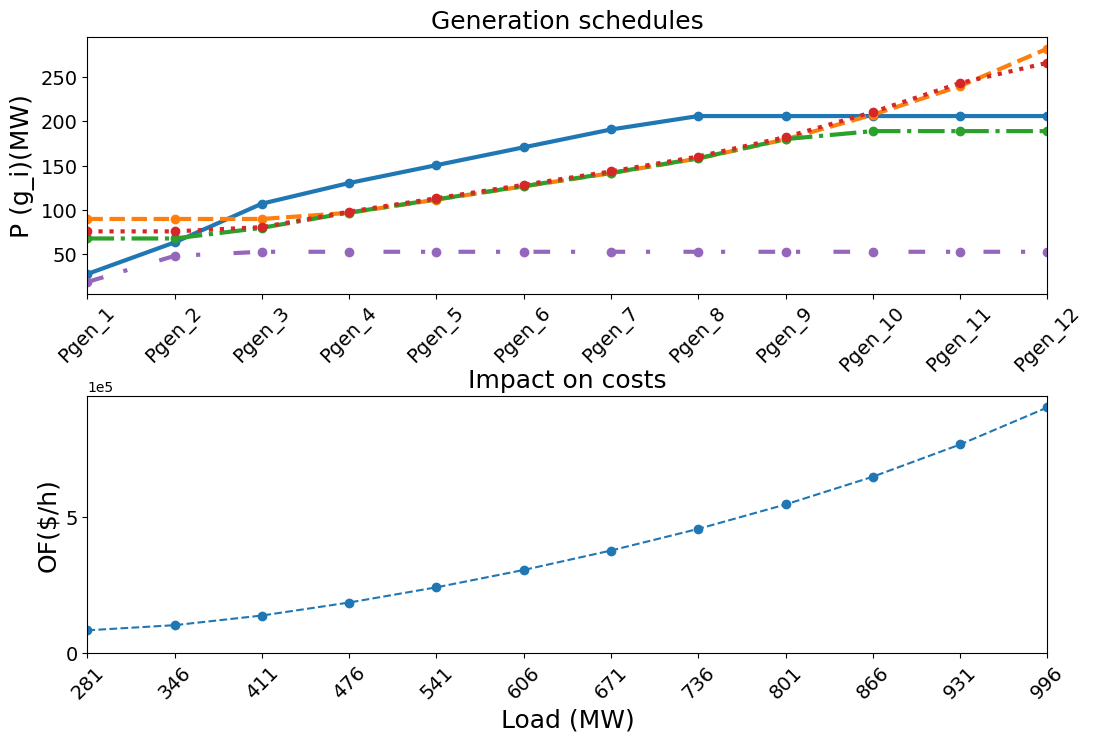

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(12, 8)) 
#plt.figure(figsize=(8, 3)) 
line_styles = ['-', '--', '-.', ':',(0, (4, 5, 1, 8))]
for i, col in enumerate(new_df.columns):
    axs[0].plot(new_df.index, new_df [col], linestyle=line_styles[i], label=col, linewidth= 3, marker = 'o',)
 
plt.xticks(range(len(new_df.index)),new_df.index)
axs[0].set_xticklabels(new_df.index, rotation=45)
axs[0].set_xlim(left=0, right=len(new_df.index) - 1)
# axs[0].set_xlim(left=0, right=len(new_df.index) - 1)
axs[0].set_ylabel('P (g_i)(MW)', fontsize=18)
axs[0].set_title('Generation schedules', fontsize=18)
axs[0].tick_params(axis='both', labelsize=14)
"Objective function"
axs[1].plot(load, obj,  marker='o', linestyle='--')
plt.ticklabel_format( axis='y', scilimits=(0,0))
plt.xlim(left=min(load), right = max(load))
plt.xlabel('Load (MW)',fontsize=18)
custom_ticks = np.arange(0, 10**6, 10**6/2)
plt.yticks(custom_ticks)
plt.ylabel('OF($/h)', fontsize=18)
plt.title("Impact on costs", fontsize=18)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_xticks(load)
axs[1].set_xticklabels(load, rotation=45)
plt.subplots_adjust(hspace=0.4, left=0.1)
plt.show()


### Stacked Bar

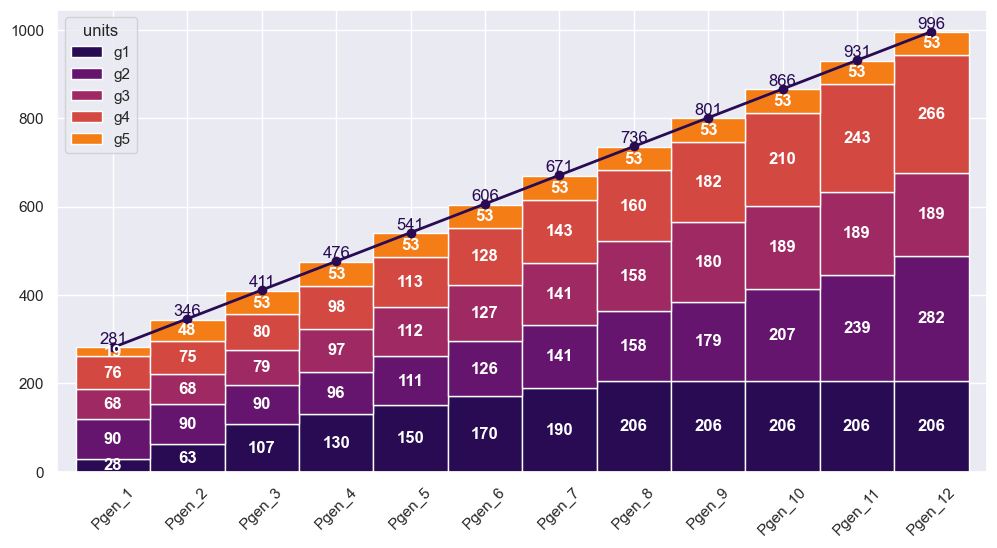

In [19]:
import seaborn as sns
plot = new_df.astype(int).plot.bar(rot=45, stacked = True, color=sns.set(palette="inferno"), subplots=False, width = 1, figsize=(12, 6))
plot.plot(load, color=sns.color_palette("inferno")[0], marker='o', linestyle='-', linewidth=2, label='Line Plot')
for container in plot.containers:
    plot.bar_label(container, label_type='center', fontsize=12, color = 'white', fontweight='bold')
for i, value in enumerate(load):
   plot.text(i, value + 1, str(value), ha='center', va='bottom', color=sns.color_palette("inferno")[0])